In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#EBTEL Heating Function Interpolation Tests

In the current implementation of EBTEL, the heating function is specified through a combination of start times, end times, and event amplitudes that are combined inside the code to form the final heating function $q(t)$. This requires a lot of extra work and it would be nice to just let the user read in any old heating function. 

However, this becomes a little tricky when the adaptive time step option is used since this means that we cannot <i>a priori</i> determine the time array. Thus, we need to come up with a way to interpolate the specified heating function on the fly.

First, let's come up with some basic parameters and construct a user-specified heating function.

In [137]:
time_total = 500
delta_time_input = 2
time_input = np.arange(0,time_total+delta_time_input,delta_time_input)

In [138]:
def heating_input(t,omega,eps_noise):
    np.random.seed()
    return (np.sin(omega*t))**2 + eps_noise*np.random.rand(len(t))

In [139]:
q1 = heating_input(time_input,1.0/(20*delta_time_input),0.1)

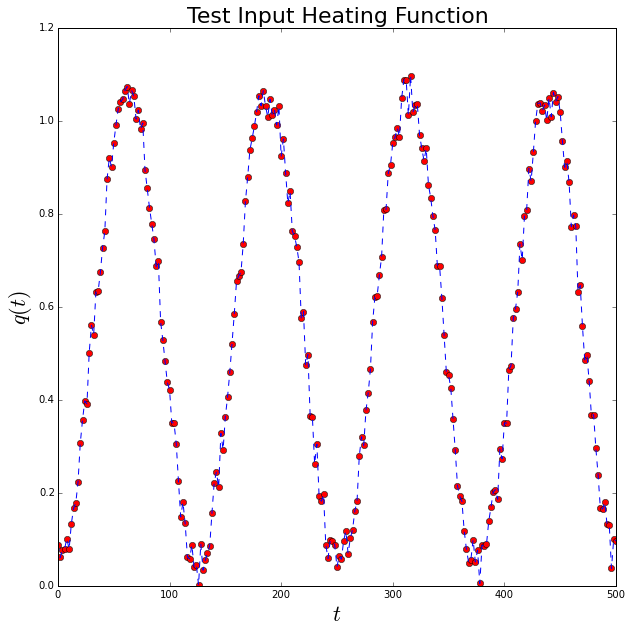

In [140]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(time_input,q1,'ro')
ax.plot(time_input,q1,'--')
ax.set_title(r'Test Input Heating Function',fontsize=22)
ax.set_xlabel(r'$t$',fontsize=22)
ax.set_ylabel(r'$q(t)$',fontsize=22)
plt.show()

Now, let's (semi-)randomly sample our time interval and try to determine the proper heating rate at each point from our user-defined heating function.

In [148]:
mean_interval = delta_time_input
eps_sigma = 0.1
t_final = time_total
t_start = 0.0
t_sim = np.array([t_start])
q_sim = np.array([])

In [152]:
np.random.seed()
while t_sim[-1] < t_final:
    #sample heating
    #first check if we can match the time exactly somewhere
    equal_inds = np.where(t_sim[-1] == time_input)
    if len(equal_inds[0]) > 0:
        q_sim = np.append(q_sim,q1[equal_inds[0][0]])
    else:
        #now consider the harder case
        lesser_inds = np.where(time_input < t_sim[-1])
        if len(lesser_inds) > 0:
            t_low = time_input[lesser_inds[0][-1]]
            q_low = q1[lesser_inds[0][-1]]
        else:
            raise ValueError("Unable to perform interpolation")
        
        greater_inds = np.where(time_input > t_sim[-1])
        if len(greater_inds) > 0:
            t_high = time_input[greater_inds[0][0]]
            q_high = q1[greater_inds[0][0]]
        else:
            raise ValueError("Unable to perform interpolation")
            
        q_interp = np.interp(np.array([t_low,t_sim[-1],t_high]),np.array([t_low,t_high]),
                            np.array([q_low,q_high]))
        q_sim = np.append(q_sim,q_interp[1])
            
    #update timestep
    interval_c = mean_interval + np.random.normal(0,eps_sigma*mean_interval,1)[0]
    t_c = t_sim[-1] + interval_c
    if t_c > t_final:
        t_sim = np.append(t_sim,t_final)
    elif t_c < t_sim[-1]:
        t_sim = np.append(t_sim,t_sim[-1] + mean_interval)
    else:
        t_sim = np.append(t_sim,t_c)

Now, plot the final results on top of the user-define heating function.

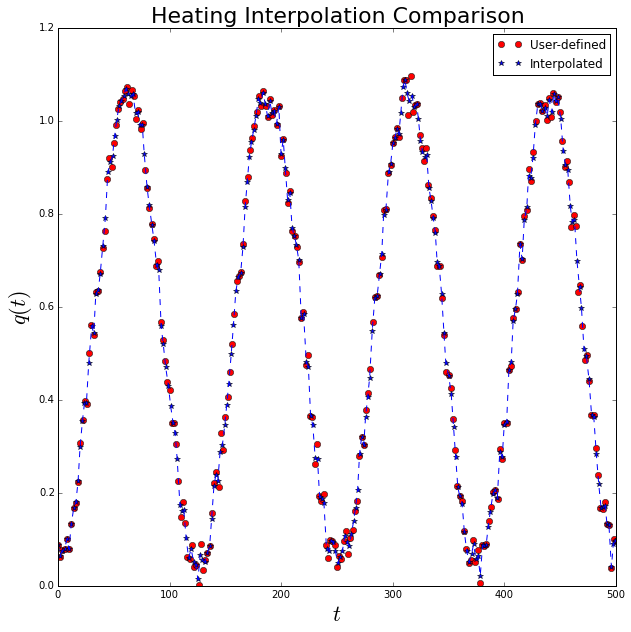

In [153]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(time_input,q1,'ro',label=r'User-defined')
ax.plot(t_sim[:-1],q_sim,'b*',label=r'Interpolated')
ax.plot(t_sim[:-1],q_sim,'--b')
ax.set_title(r'Heating Interpolation Comparison',fontsize=22)
ax.set_xlabel(r'$t$',fontsize=22)
ax.set_ylabel(r'$q(t)$',fontsize=22)
ax.legend()
plt.show()

Judging from the above results, we should be able to adequately sample our user-defined heating function, provided it is of significant resolution, when we use the adaptive solver option in EBTEL.